# Modelling the air sources with HYSPLIT

```{contents}
:local:
:depth: 2
```

## Preamble

### Imports

In [1]:
import shutil
import shapely
import pysplit
import warnings


import numpy as np
import pandas as pd
import plotnine as p9
import geopandas as gpd

from glob import glob
from functools import partial
from itertools import product
from mizani.breaks import date_breaks
from shapely.geometry import LineString
from mizani.formatters import date_format, custom_format

/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Presets

In [3]:
p9.options.set_option('dpi', 200)
p9.options.set_option('figure_size', (4, 3))
p9.options.set_option('base_family', 'Bitstream Vera Serif')
p9.theme_set(p9.theme_bw() + p9.theme(axis_text=p9.element_text(size=7),
                                      axis_title=p9.element_text(size=9)))

# Not advisable, but in this case the warnings become too much.
warnings.filterwarnings("ignore")

In [4]:
# negative log function for ease of plotting later
def negative_log(x):
    return np.sign(x) * np.log10(np.abs(x))

## Loading data

In [5]:
shape_url = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(shape_url)

In [6]:
metals = pd.read_csv('../data/long_metals.csv', index_col=0)

In [7]:
HYSPLIT_DIR = '/home/afontal/utils/hysplit/exec/hyts_std'
HYSPLIT_WORKING = '/home/afontal/utils/hysplit/working'
METEO_DIR = '/home/afontal/utils/hysplit/meteo/gdas1'
OUT_DIR = '/home/afontal/projects/kd_subweekly_cycle/output/trajectories'

## Analysis

### Kumamoto (Mar-Apr 2011)

#### Trajectory Generation

We are going to generate 96 hour backtrajectories starting in Kumamoto (32°48'N, 130°41'E), at an initial height of 10m. We will generate a total of 8 trajectories per day to be able to estimate the daily variability in air sources.

In [ ]:
pysplit.generate_bulktraj('kumamoto',
                          hysplit_working=HYSPLIT_WORKING,
                          hysplit=HYSPLIT_DIR,
                          output_dir=f'{OUT_DIR}/kumamoto',
                          meteo_dir=METEO_DIR,
                          years=[2011],
                          months=[3, 4],
                          meteoyr_2digits=True,
                          hours=range(0, 24, 3),
                          altitudes=[10],
                          coordinates=(32.80589, 130.69181),
                          run=-96,
                          meteo_bookends=([4, 5], [])
    )

In [14]:
all_trajs = pysplit.make_trajectorygroup(glob(f'{OUT_DIR}/kumamoto/*'))

In [15]:
all_trajectories_data = (pd.concat([t.data.assign(traj_id=i) for i, t in enumerate(all_trajs)])
                         .drop(columns=['Temperature_C',  'Temperature', 'Mixing_Depth'])
                         .assign(start_time=lambda dd: dd.DateTime - pd.to_timedelta(dd.Timestep, unit='h'))
                         .assign(date=lambda dd: pd.to_datetime(dd.start_time.dt.date))
)


In [16]:
trajectory_lines = (all_trajectories_data
                    .groupby(['traj_id', 'start_time'], as_index=False)
                    ['geometry']
                    .apply(lambda x: LineString([(i.x, i.y) for i in x.to_list()]))
                    .assign(date=lambda dd: pd.to_datetime(dd.start_time.dt.date))
                    .assign(hour=lambda dd: dd.start_time.dt.hour)
)

##### Example of a day of trajectories

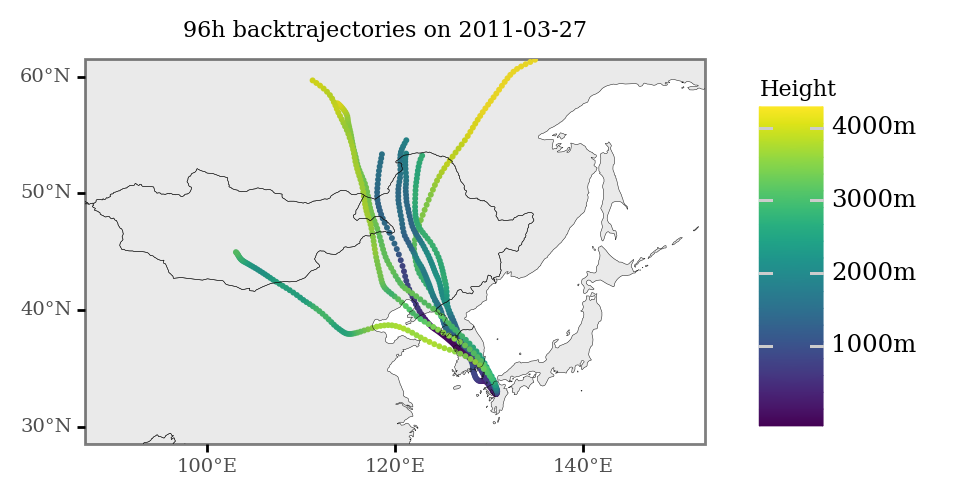

<ggplot: (8788647765206)>

In [277]:
(all_trajectories_data
.loc[lambda dd: dd.date == '2011-03-27']
.pipe(lambda dd: p9.ggplot(dd) 
      + p9.geom_map(p9.aes(color='geometry.z', fill='geometry.z'), size=.2)
       + p9.geom_map(world, alpha=.1, size=.1)
       + p9.theme(figure_size=(4, 2.5), title=p9.element_text(size=8), panel_grid=p9.element_blank())
       + p9.labs(title=f'96h backtrajectories on 2011-03-27', fill='Height', color='Height')
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(90, 150))
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(30, 60))
       + p9.scale_fill_continuous(labels=custom_format('{:0g}m'))
       + p9.scale_color_continuous(labels=custom_format('{:0g}m'))
       )
)

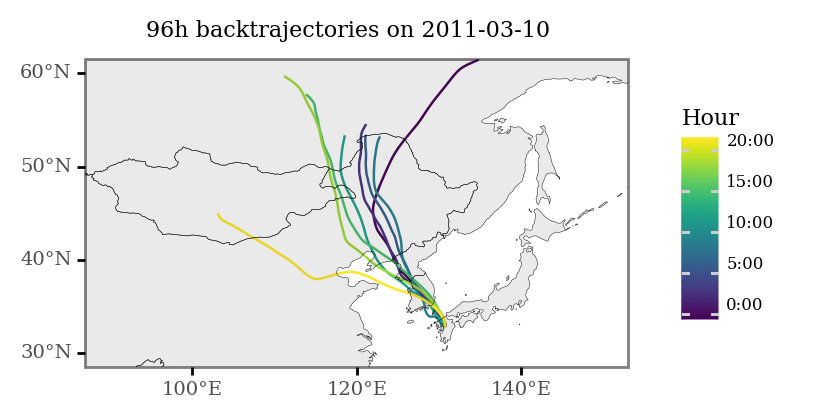

<ggplot: (8788647819698)>

In [278]:
(trajectory_lines
.loc[lambda dd: dd.date == '2011-03-27']
.pipe(lambda dd: p9.ggplot(dd) 
      + p9.geom_map(p9.aes(color='hour'))
       + p9.geom_map(world, alpha=.1, size=.1)
       + p9.theme(figure_size=(3.5, 2),
                  title=p9.element_text(size=8),
                  panel_grid=p9.element_blank(),
                  legend_key_size=9, legend_text=p9.element_text(size=6, va='center'))
       + p9.labs(title=f'96h backtrajectories on 2011-03-10', fill='Height', color='Hour')
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(90, 150))
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(30, 60))
       + p9.scale_color_continuous(labels=custom_format('{:0g}:00'))
       )
)


#### Epidemiological context (KD)

In [280]:
kd_kumamoto = (pd.read_csv('../data/kd_ts.csv', index_col=0)
               .assign(date=lambda dd: pd.to_datetime(dd['date']))
               
)

In [281]:
kd_kumamoto_2011 = (pd.read_excel('../data/kd_daily.xlsx')
         .assign(date=lambda dd: pd.to_datetime(dd['Dates']))
         .loc[lambda dd: (dd.date >= '2011') & (dd.date < '2012')]
         .assign(cases=lambda dd: dd[43].astype(int))
         [['date', 'cases']]
)

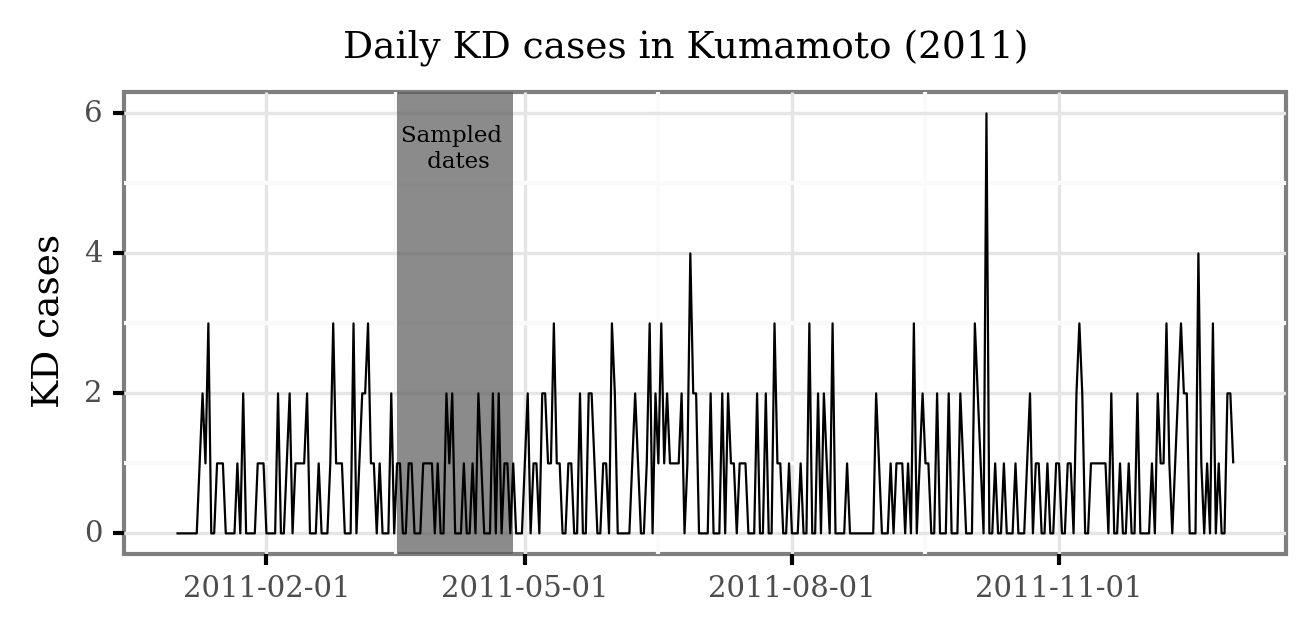

<ggplot: (8788649337242)>

In [282]:
(p9.ggplot(kd_kumamoto_2011)
 + p9.aes('date', 'cases')
 + p9.annotate(geom='rect', ymin=-np.inf, ymax=np.inf, xmin=dates.min(), xmax=dates.max(), alpha=.7)
 + p9.annotate(geom='text', y=5.5, x=dates.median(), label='Sampled \n dates', size=5.5)
 + p9.geom_line(size=.3, alpha=1)
 + p9.scale_x_datetime(breaks=date_breaks('3 months'))
 + p9.theme(figure_size=(5, 2), title=p9.element_text(size=9), dpi=300)
 + p9.labs(x='', y='KD cases', title='Daily KD cases in Kumamoto (2011)')
)

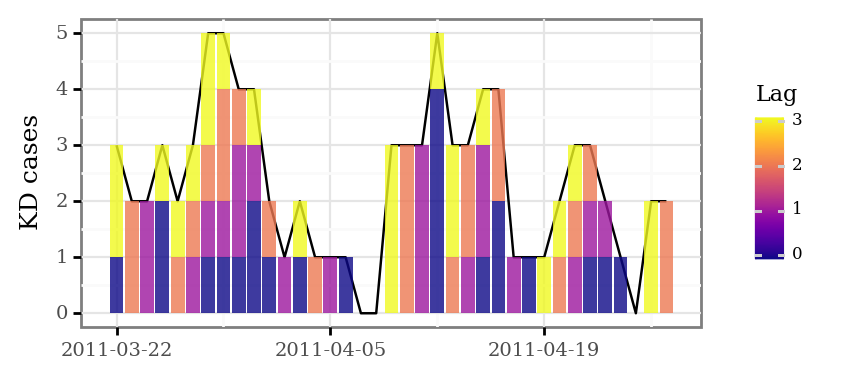

<ggplot: (8788651142455)>

In [285]:
(kd_kumamoto
 .melt(['date', 'kd_rolling_4'])
 .assign(variable=lambda dd: dd.variable.str[-1].astype(int))
 .pipe(lambda dd: p9.ggplot(dd)
      + p9.aes('date', 'value', fill='variable')
      + p9.geom_line(p9.aes(y='kd_rolling_4'))
      + p9.geom_col(alpha=.8)
      + p9.scale_fill_continuous('plasma')
      + p9.scale_x_datetime(breaks=date_breaks('2 weeks'))
      + p9.labs(x='', y='KD cases', fill='Lag')
      + p9.theme(figure_size=(4, 2), legend_key_size=7,
                 legend_text=p9.element_text(size=6, va='bottom'),
                 legend_title=p9.element_text(size=8))
      )
)

#### Selecting days of KD maxima and minima

In [283]:
dates_minima = kd_kumamoto.loc[lambda dd: dd.kd_rolling_4 <= 0].date
dates_maxima = kd_kumamoto.loc[lambda dd: dd.kd_rolling_4 >= 5].date

min_max_trajectories = (trajectory_lines
                       .loc[trajectory_lines.date.isin(dates_minima)]
                       .assign(group='Minima')
                       .append(trajectory_lines
                              .loc[trajectory_lines.date.isin(dates_maxima)]
                              .assign(group='Maxima'))
 .dropna()
 .pipe(gpd.GeoDataFrame)
)

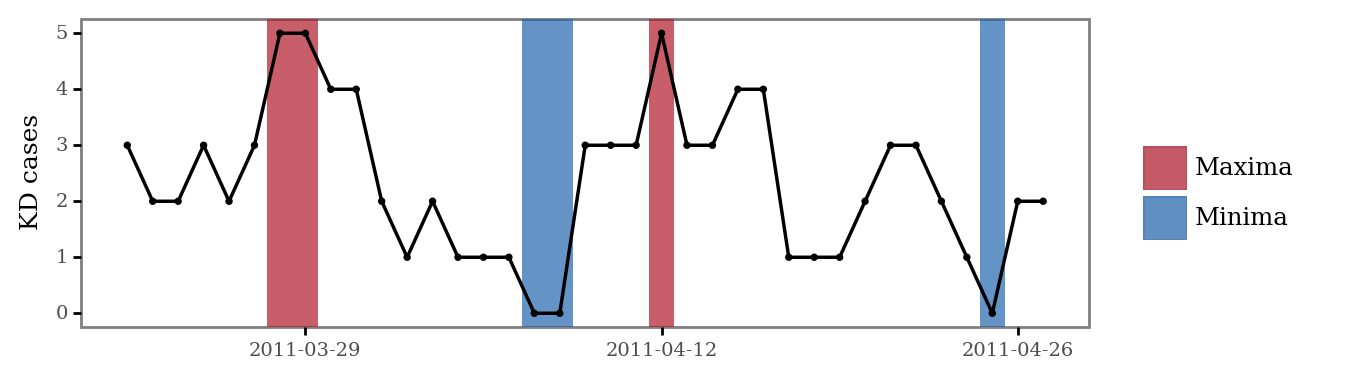

In [284]:
(p9.ggplot(kd_kumamoto)
 + p9.aes('date', 'kd_rolling_4')
 + p9.geom_rect(p9.aes(fill='group', ymin=-np.inf, ymax=np.inf,
                xmin='date - pd.to_timedelta("12 h")', xmax='date + pd.to_timedelta("12 h")'),
                inherit_aes=False, alpha=.7, data=min_max_trajectories[['date', 'group']].drop_duplicates())
 + p9.geom_line(size=.7)
 + p9.geom_point(size=.5)
 + p9.scale_fill_manual(['#B2182B', '#2166AC'])
 + p9.scale_x_datetime(breaks=date_breaks('2 weeks'))
 + p9.labs(x='', y='KD cases', fill='')
 + p9.theme(figure_size=(6.5, 2), panel_grid=p9.element_blank())

).draw().savefig('../output/figures/kumamoto_kd_minmax.pdf', bbox_inches='tight')

#### Representation of all trajectories

In [287]:
from shapely.geometry import Polygon

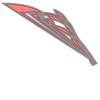

In [291]:
Polygon(all_trajectories_data.loc[lambda dd: dd.date=='2011-04-01'].geometry.values)

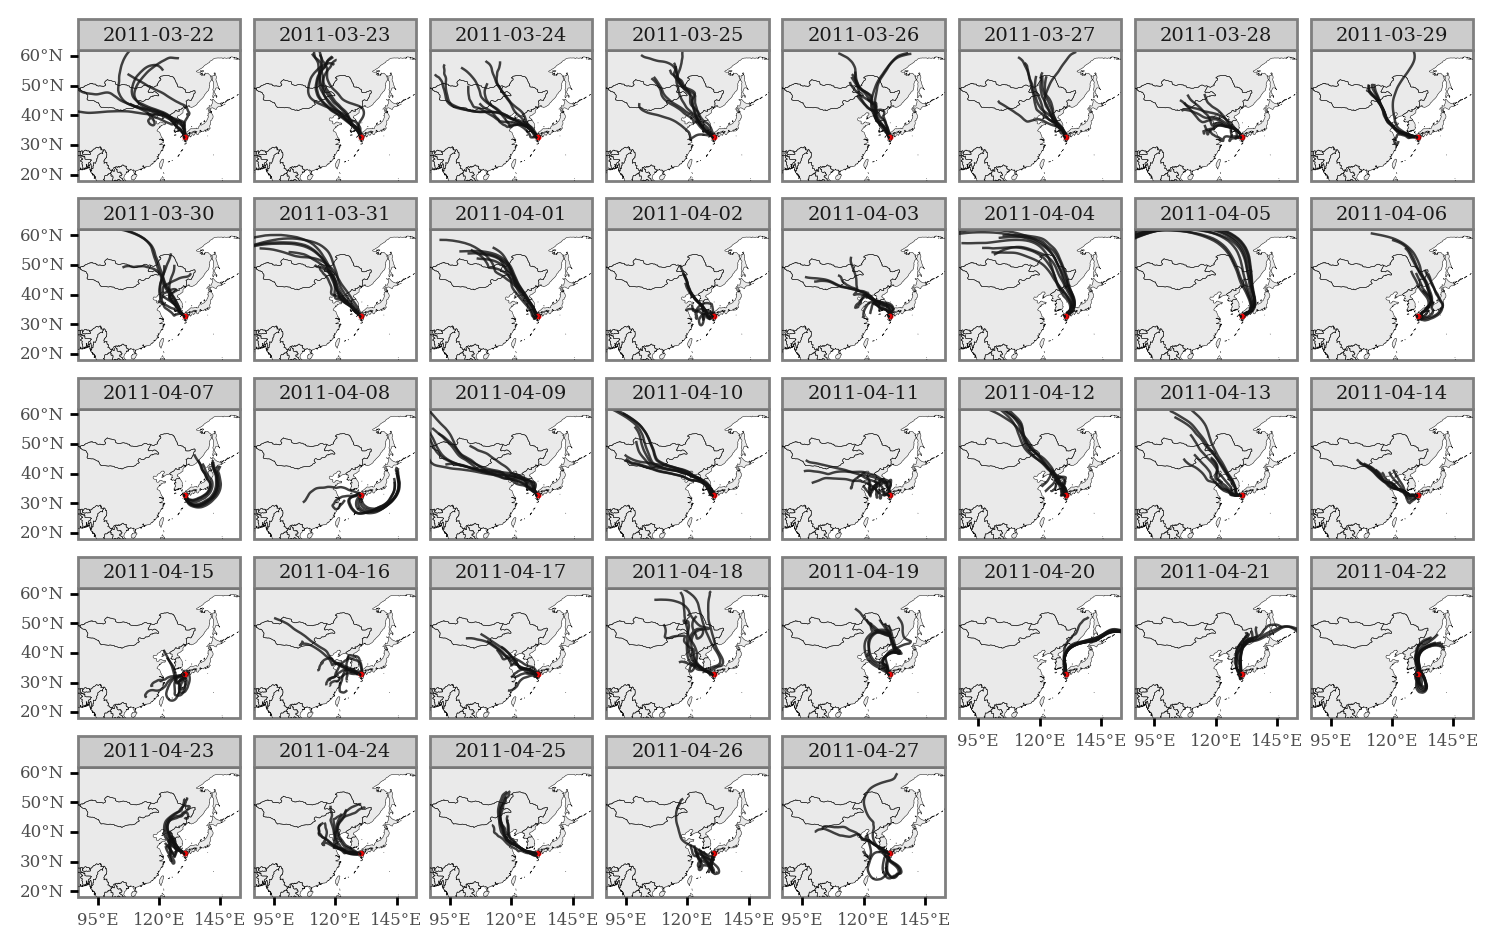

<ggplot: (8788654129821)>

In [123]:
(trajectory_lines
 .loc[lambda dd: dd.date.isin(kd_kumamoto.date)]
 .assign(date=lambda dd: dd.date.astype(str))
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map(alpha=.8)
       + p9.annotate(geom='point', size=.2, color='red', y=32.80589, x=130.69181)
       + p9.geom_map(world, alpha=.1, size=.1)
       + p9.theme(figure_size=(9, 5.5),
                  title=p9.element_text(size=8),
                  axis_text=p9.element_text(size=6),
                  panel_grid=p9.element_blank(),
                  strip_text=p9.element_text(size=7))
       + p9.labs(title=f'', x='', y='')
       + p9.facet_wrap('date', ncol=8)
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(90, 150), breaks=[95, 120, 145])
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(20, 60)))
)

##### Backtrajectories of KD maxima vs minima

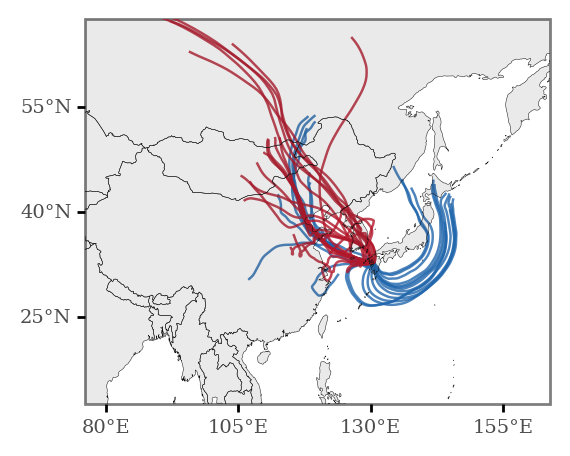

In [127]:
(p9.ggplot(min_max_trajectories) 
+ p9.geom_map(p9.aes(color='group', fill='group'), alpha=.8) 
+ p9.geom_map(size=.1, alpha=.1, data=world)
+ p9.labs(fill='', color='')
+ p9.scale_fill_manual(['#B2182B', '#2166AC'])
+ p9.scale_color_manual(['#B2182B', '#2166AC'])
+ p9.guides(fill=False, color=False)
+ p9.theme(title=p9.element_text(size=9), panel_grid=p9.element_blank(), figure_size=(3, 2.5))
      + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(80, 160), breaks=[80, 105, 130, 155])
      + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(15, 65), breaks=[25, 40, 55])
).draw().savefig('../output/figures/kumamoto_trajectories.pdf', bbox_inches='tight')

#### Computing differences by grid cells

In [128]:
margin = 1
xmin, ymin, xmax, ymax = min_max_trajectories.total_bounds.round() + [-margin, -margin, margin, margin]
n_cells = 60
cell_size = (xmax - xmin) / n_cells
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
grid = (gpd.GeoDataFrame(grid_cells, columns=['geometry'])
        .assign(cell=lambda dd: dd.geometry)
        .assign(x=lambda dd: dd.cell.centroid.x, y=lambda dd: dd.cell.centroid.y)
)

x_y_poly = grid[['x', 'y', 'cell']].drop_duplicates()
grid_intersections = gpd.sjoin(min_max_trajectories, grid, op='intersects')

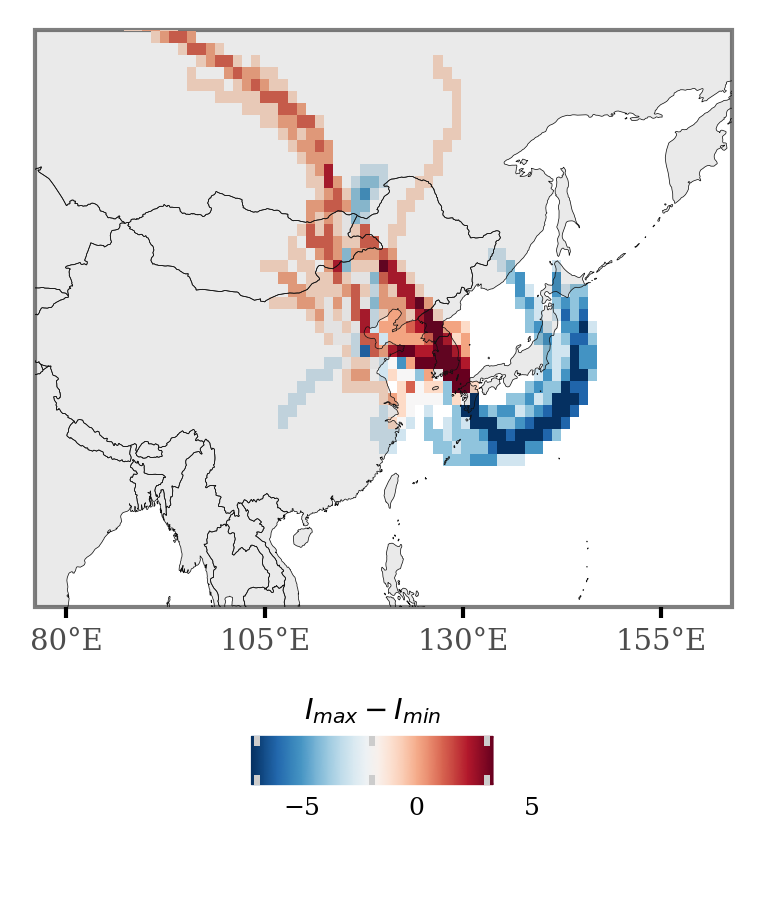

In [129]:
(grid_intersections
 .groupby(['x', 'y', 'group'])
 .size()
 .rename('n')
 .reset_index()
 .pivot(['x', 'y'], 'group', 'n')
 .fillna(0)
 .assign(diff=lambda dd: dd['Maxima'] - dd['Minima'])
 .assign(fc=lambda dd: np.log2(dd['Maxima'] / dd['Minima']))
 .sort_values('diff')
 .reset_index()
 .merge(x_y_poly)
 .assign(total_n=lambda dd: dd['Maxima'] + dd['Minima'])
 .loc[lambda dd: dd.total_n >= 0]
 .sort_values('fc')
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map(p9.aes(fill='diff', geometry='cell'), size=.0)
       + p9.geom_map(data=world, size=.1, alpha=.1)
       + p9.scale_fill_continuous('RdBu_r', limits=(-5, 5), breaks=[-5, 0, 5])
       + p9.scale_alpha_continuous(trans='log10')
       + p9.theme(dpi=300, panel_grid=p9.element_blank(), plot_background=p9.element_blank(),
                  legend_background=p9.element_blank(), legend_key_size=8,
                  legend_text=p9.element_text(size=6, va='bottom', ha='center'), legend_title_align='center',
                  legend_title=p9.element_text(size=7), figure_size=(3, 2.5), legend_position='bottom',
                   axis_text_y=p9.element_blank(), axis_ticks_major_y=p9.element_blank())
       + p9.labs(fill='$I_{max} - I_{min}$', x='', y='')
      + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(80, 160), breaks=[80, 105, 130, 155])
      + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(15, 65), breaks=[25, 40, 55])
)).draw().savefig('../output/figures/kumamoto_max_minus_min.pdf', bbox_inches='tight')

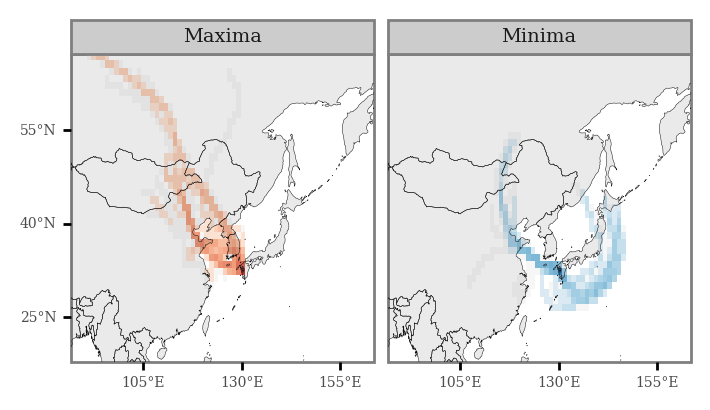

In [130]:
(grid_intersections
 .groupby(['x', 'y', 'group'])
 .size()
 .rename('n')
 .reset_index()
 .merge(x_y_poly)
 .assign(n=lambda dd: np.where(dd.group=='Minima', -dd.n, dd.n))
 .assign(n=lambda dd: negative_log(dd.n))
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map(p9.aes(fill='n', geometry='cell'), size=0)
       + p9.geom_map(data=world, size=.1, alpha=.1)
       + p9.facet_wrap(['group'], ncol=2)
       + p9.theme(dpi=200, panel_grid=p9.element_blank(), figure_size=(4, 2),
                  axis_text=p9.element_text(size=5), strip_text=p9.element_text(size=7))
       + p9.labs(fill='')
       + p9.scale_fill_continuous('RdBu_r', limits=(-2, 2))
       + p9.scale_alpha_continuous(trans='sqrt')
       + p9.guides(fill=False, alpha=False)
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(90, 160), breaks=[105, 130, 155])
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(20, 65), breaks=[25, 40, 55]))
).draw().savefig('../output/figures/kumamoto_grids.pdf', bbox_inches='tight')

#### Trajectories height distribution

In [233]:
min_max_trajectories_data = (all_trajectories_data
                            .loc[lambda dd: dd.date.isin(dates_minima)]
                            .assign(group='KD Minima')
                            .append(all_trajectories_data
                                    .loc[lambda dd: dd.date.isin(dates_maxima)]
                                    .assign(group='KD Maxima'))
)

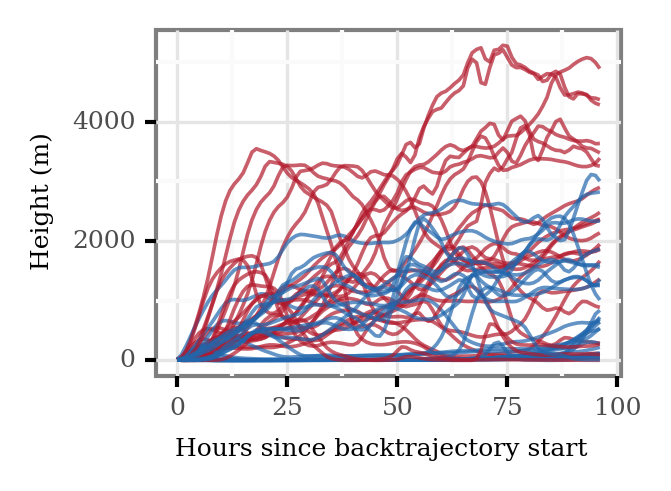

<ggplot: (8788648318320)>

In [275]:
(min_max_trajectories_data
 .assign(height=lambda dd: dd.geometry.z)
 .pipe(lambda dd: p9.ggplot(dd)
  + p9.aes('-Timestep', 'height', color='group')
  + p9.scale_color_manual(['#B2182B', '#2166AC'])
  + p9.guides(color=False)
  + p9.geom_line(p9.aes(group='traj_id'), alpha=.7, size=.5)
  + p9.theme(figure_size=(2, 1.5), dpi=300, axis_text=p9.element_text(size=6), 
             axis_title=p9.element_text(size=6), legend_text=p9.element_text(size=6),
             legend_key_size=8)
  + p9.labs(x='Hours since backtrajectory start', y='Height (m)', color='')
 )
 
)

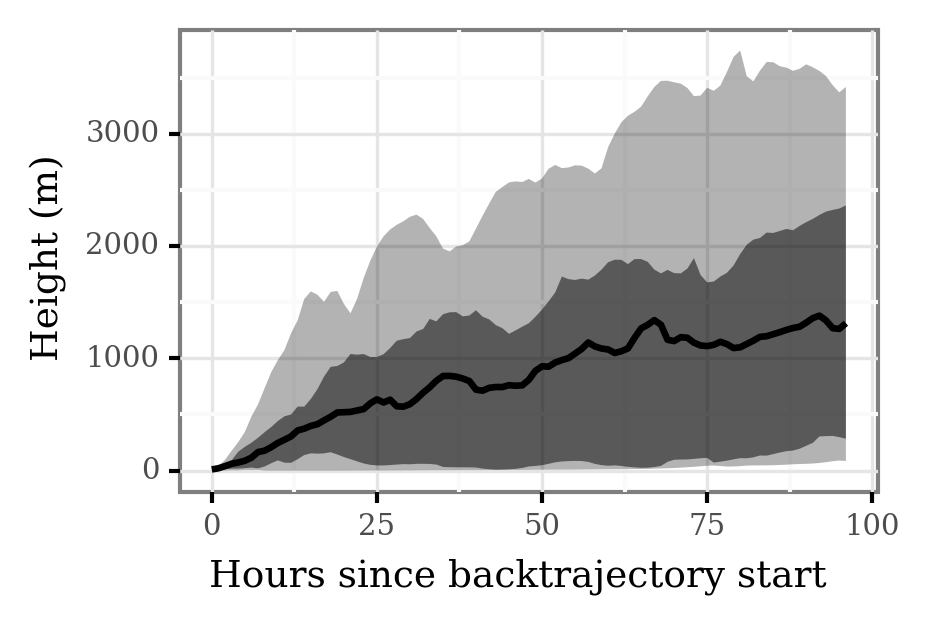

<ggplot: (8788652301945)>

In [252]:
(min_max_trajectories_data
 .loc[lambda dd: dd['date'].isin(kd_kumamoto.date)]
 .assign(height=lambda dd: dd.geometry.z)
 .pipe(lambda dd: p9.ggplot(dd)
  + p9.aes('-Timestep', 'height')
  + p9.stat_summary(geom='line', fun_y=np.median, size=.9)
  + p9.stat_summary(geom='ribbon', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75), fill='black', alpha=.5)
  + p9.stat_summary(geom='ribbon', fun_ymin=partial(np.percentile, q=10), fun_ymax=partial(np.percentile, q=90), fill='black', alpha=.3)
  + p9.labs(x='Hours since backtrajectory start', y='Height (m)')
  + p9.theme(figure_size=(3, 2), dpi=300)
 )
)

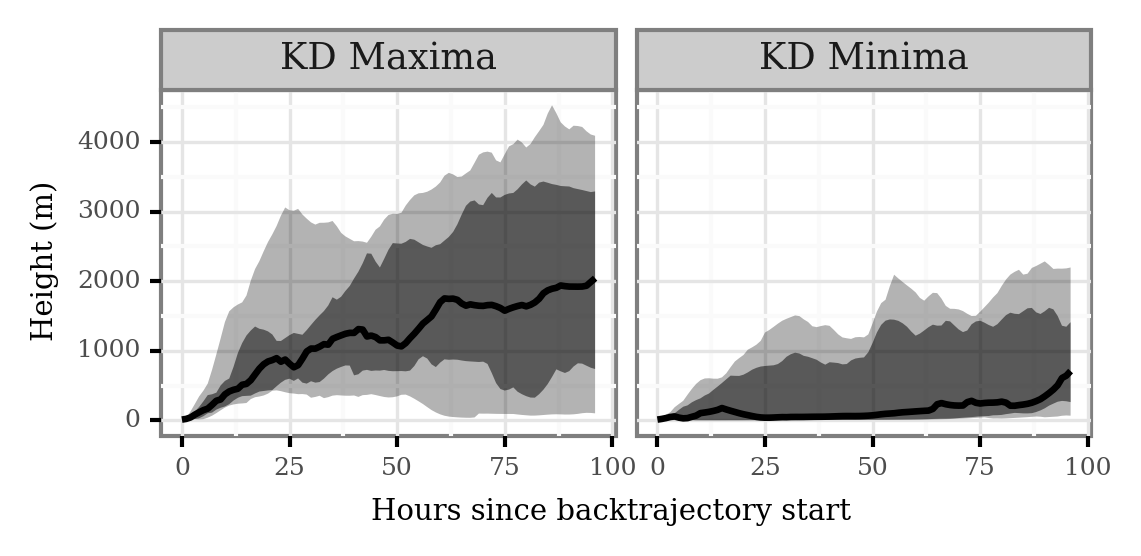

<ggplot: (8788648240291)>

In [274]:
(min_max_trajectories_data
 .loc[lambda dd: dd['date'].isin(kd_kumamoto.date)]
 .assign(height=lambda dd: dd.geometry.z)
 .pipe(lambda dd: p9.ggplot(dd)
  + p9.aes('-Timestep', 'height')
  + p9.stat_summary(geom='line', fun_y=np.median, size=.9)
  + p9.stat_summary(geom='ribbon', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75), fill='black', alpha=.5)
  + p9.stat_summary(geom='ribbon', fun_ymin=partial(np.percentile, q=10), fun_ymax=partial(np.percentile, q=90), fill='black', alpha=.3)
  + p9.labs(x='Hours since backtrajectory start', y='Height (m)')
  + p9.theme(figure_size=(4, 1.5), dpi=300, axis_text=p9.element_text(size=6), 
             axis_title=p9.element_text(size=7), legend_text=p9.element_text(size=6),
             legend_key_size=8)
  + p9.facet_wrap('group')
 )
)

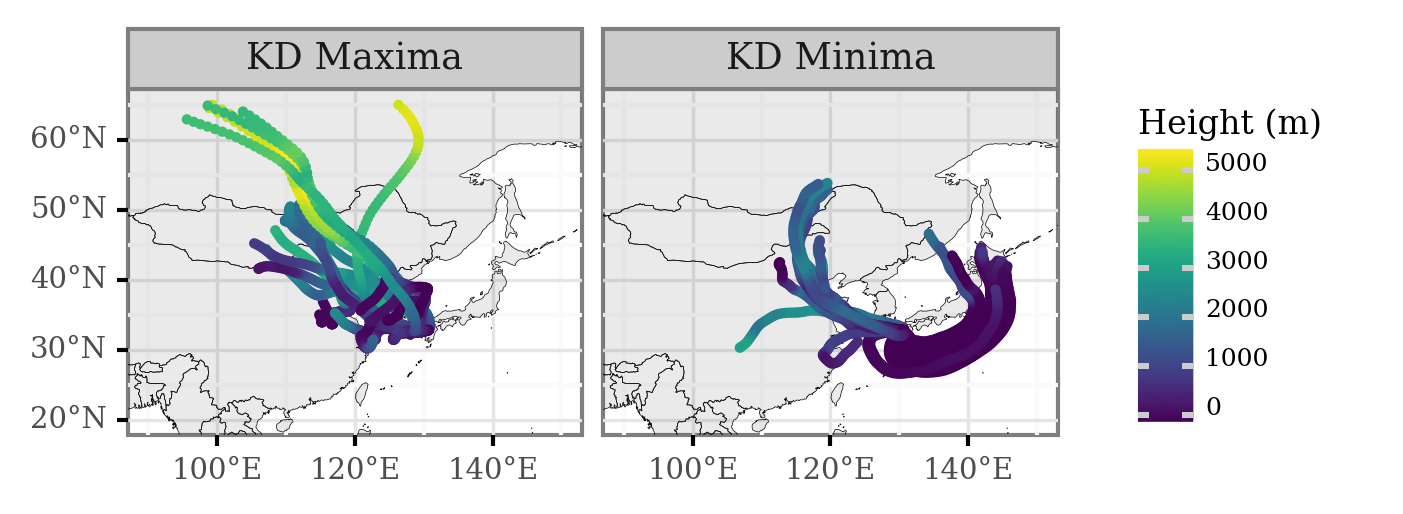

<ggplot: (8788648211857)>

In [272]:
(min_max_trajectories_data
 .pipe(lambda dd: p9.ggplot(dd)
      + p9.geom_map(data=world, size=.1, alpha=.1)
      + p9.geom_point(p9.aes('geometry.x', 'geometry.y', color='geometry.z'), size=.4)
      + p9.facet_wrap('group')
      + p9.scale_x_continuous(labels=custom_format('{:0g}°E'),
                              limits=(90, 150))
      + p9.scale_y_continuous(labels=custom_format('{:0g}°N'),
                              limits=(20, 65))
      + p9.labs(x='', y='', color='Height (m)')
      + p9.theme(figure_size=(4, 1.5),
                 legend_key_size=9,
                 legend_title=p9.element_text(size=8),
                 legend_text=p9.element_text(size=6, va='baseline'), dpi=300)
  
 ) 
)


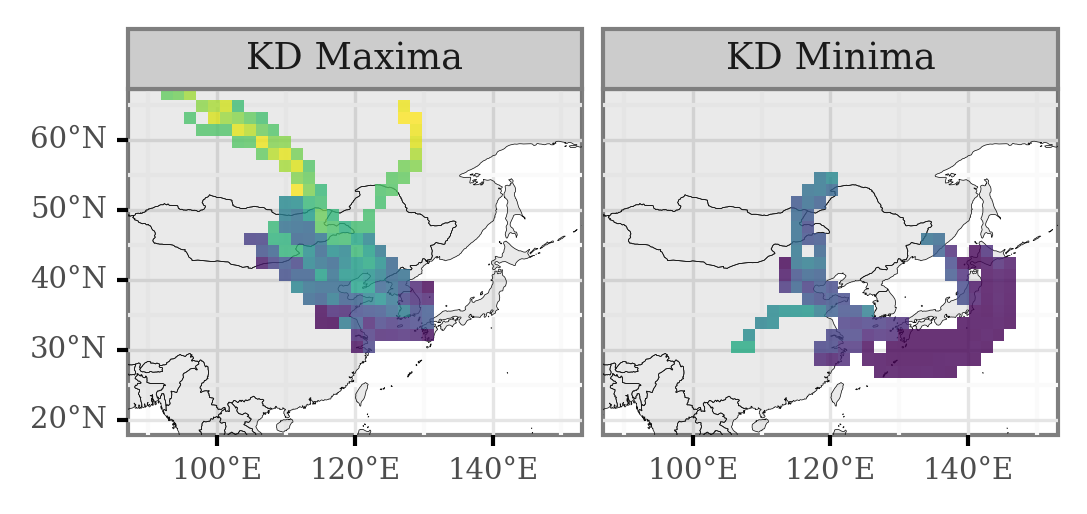

<ggplot: (8788648062317)>

In [273]:
(gpd
 .sjoin(min_max_trajectories_data, grid, op='within')
 .assign(height=lambda dd: dd.geometry.z)
 .groupby(['group', 'x', 'y'])
 ['height'].mean()
 .reset_index()
 .merge(x_y_poly)
 .pipe(lambda dd: p9.ggplot(dd)
        + p9.geom_map(data=world, size=.1, alpha=.1)
        + p9.geom_map(p9.aes(geometry='cell', fill='height'), alpha=.8, color=None)
        + p9.scale_x_continuous(labels=custom_format('{:0g}°E'),
                                limits=(90, 150))
        + p9.scale_y_continuous(labels=custom_format('{:0g}°N'),
                                limits=(20, 65))
        + p9.labs(x='', y='', fill='Height (m)')
        + p9.facet_wrap('group')
        + p9.guides(fill=False)
        + p9.theme(figure_size=(4, 1.5),
                   legend_key_size=9,
                   legend_title=p9.element_text(size=8),
                   legend_text=p9.element_text(size=6, va='baseline'), dpi=300)
 )
)

### All of Japan (2010-2016)

In [286]:
kd_ts = (pd.read_excel('../data/kd_daily.xlsx')
         .assign(date=lambda dd: pd.to_datetime(dd['Dates']))
         .assign(cases=lambda dd: dd['Japan'].astype(int))
         [['date', 'cases']]
         .loc[lambda dd: dd['date']>='2010']
)

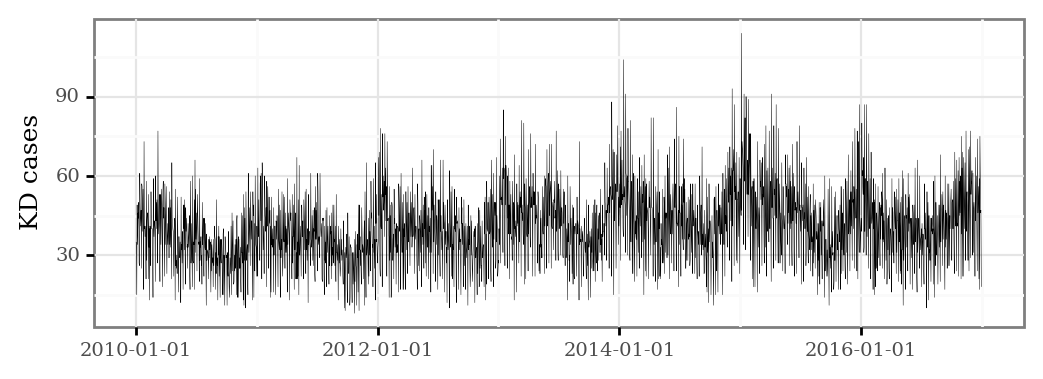

<ggplot: (8791578540590)>

In [21]:
(p9.ggplot(kd_ts) 
+ p9.aes('date', 'cases') 
+ p9.geom_line(size=.1)
+ p9.theme(figure_size=(6, 2))
+ p9.labs(x='', y='KD cases')
+ p9.scale_x_datetime(breaks=date_breaks('2 years'))
)

In [22]:
full_min_max_ts = (kd_ts
.sort_values('cases')
.reset_index(drop=True)
.assign(q=lambda dd: dd.index / dd.shape[0])
.sort_values('date')
.assign(group=lambda dd: dd.q.apply(lambda q: 'Maxima' if q >= .95 else ('Minima' if q <= .05 else pd.NA)))
.dropna()
)

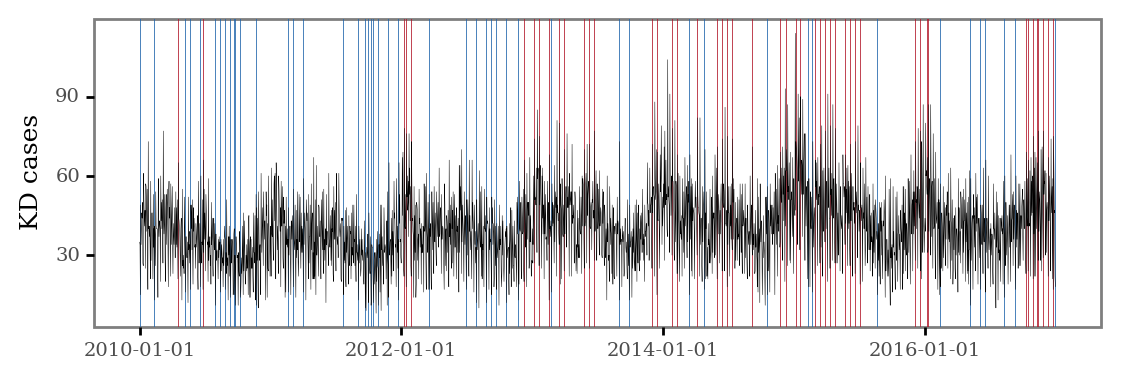

In [23]:
(p9.ggplot(kd_ts) 
 + p9.aes('date', 'cases') 
 + p9.geom_rect(p9.aes(fill='group', ymin=-np.inf, ymax=np.inf,
                xmin='date - pd.to_timedelta("12 h")', xmax='date + pd.to_timedelta("12 h")'),
                inherit_aes=False, alpha=.8, data=full_min_max_ts)
 + p9.geom_line(size=.1)
 + p9.theme(figure_size=(6.5, 2), panel_grid=p9.element_blank())
 + p9.scale_fill_manual(['#B2182B', '#2166AC'])
 + p9.guides(fill=False)
 + p9.labs(x='', y='KD cases', fill='')
 + p9.scale_x_datetime(breaks=date_breaks('2 years'))
).draw().savefig('../output/figures/japan_kd_minmax.pdf', bbox_inches='tight')

In [ ]:
for year, month in product(range(2010, 2017), range(1, 13)):
    pysplit.generate_bulktraj('tokyo',
                              hysplit_working=HYSPLIT_WORKING,
                              hysplit=HYSPLIT_DIR,
                              output_dir=f'{OUT_DIR}/japan',
                              meteo_dir=METEO_DIR,
                              years=[year],
                              months=[month],
                            
                              meteoyr_2digits=True,
                              hours=[0, 6, 12, 18],
                              altitudes=[10],
                              coordinates=(35.68, 139.65),
                              run=-96,
                              meteo_bookends=([4, 5], [])

    )

In [ ]:
for date in full_min_max_ts.date:
    date = str(date).replace('-', '').split(' ')[0]
    for file in glob(f'../output/trajectories/japan/*{date}*'):
        shutil.copy(file, '../output/trajectories/japan/min_max_dates/')

In [ ]:
relevant_trajs = pysplit.make_trajectorygroup(glob('../output/trajectories/japan/min_max_dates/*'))

In [ ]:
relevant_trajectories_data = (
    pd.concat([t.data.assign(traj_id=i) for i, t in enumerate(relevant_trajs)])
      .drop(columns=['Temperature_C',  'Temperature', 'Mixing_Depth'])
      .assign(start_time=lambda dd: dd.DateTime - pd.to_timedelta(dd.Timestep, unit='h'))
      .rename(columns={'start_time': 'date'})
      .loc[lambda dd: dd.date.isin(full_min_max_ts.date)]
)

In [ ]:
full_trajectory_lines = (relevant_trajectories_data
                        .groupby(['traj_id', 'date'], as_index=False)
                        ['geometry']
                        .apply(lambda x: LineString([(i.x, i.y) for i in x.to_list()]))
                        .assign(date=lambda dd: pd.to_datetime(dd.date.dt.date))
                        .assign(hour=lambda dd: dd.date.dt.hour)
                        .merge(full_min_max_ts)
                        .pipe(gpd.GeoDataFrame)
)

In [ ]:
full_trajectory_lines.groupby('group').size() / 4

group
Maxima    31.75
Minima    32.00
dtype: float64

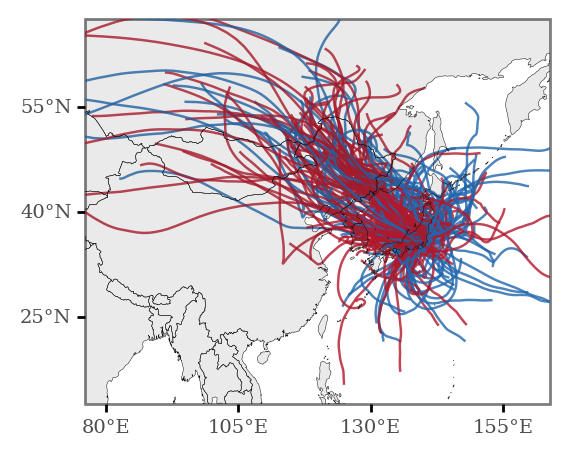

In [ ]:
(p9.ggplot(full_trajectory_lines) 
+ p9.geom_map(p9.aes(color='group', fill='group'), alpha=.8) 
+ p9.geom_map(size=.1, alpha=.1, data=world)
+ p9.labs(fill='', color='')
+ p9.scale_fill_manual(['#B2182B', '#2166AC'])
+ p9.scale_color_manual(['#B2182B', '#2166AC'])
+ p9.guides(fill=False, color=False)
+ p9.theme(title=p9.element_text(size=9), panel_grid=p9.element_blank(), figure_size=(3, 2.5),
           plot_background=p9.element_blank())
      + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(80, 160), breaks=[80, 105, 130, 155])
      + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(15, 65), breaks=[25, 40, 55])
).draw().savefig('../output/figures/japan_min_max_trajectories.pdf', bbox_inches='tight')

In [ ]:
margin = 1
xmin, ymin, xmax, ymax = full_trajectory_lines.total_bounds.round() + [-margin, -margin, margin, margin]
n_cells = 180
cell_size = (xmax - xmin) / n_cells
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
grid = (gpd.GeoDataFrame(grid_cells, columns=['geometry'])
        .assign(cell=lambda dd: dd.geometry)
        .assign(x=lambda dd: dd.cell.centroid.x, y=lambda dd: dd.cell.centroid.y)
)

x_y_poly = grid[['x', 'y', 'cell']].drop_duplicates()
grid_intersections = gpd.sjoin(full_trajectory_lines, grid, op='intersects')

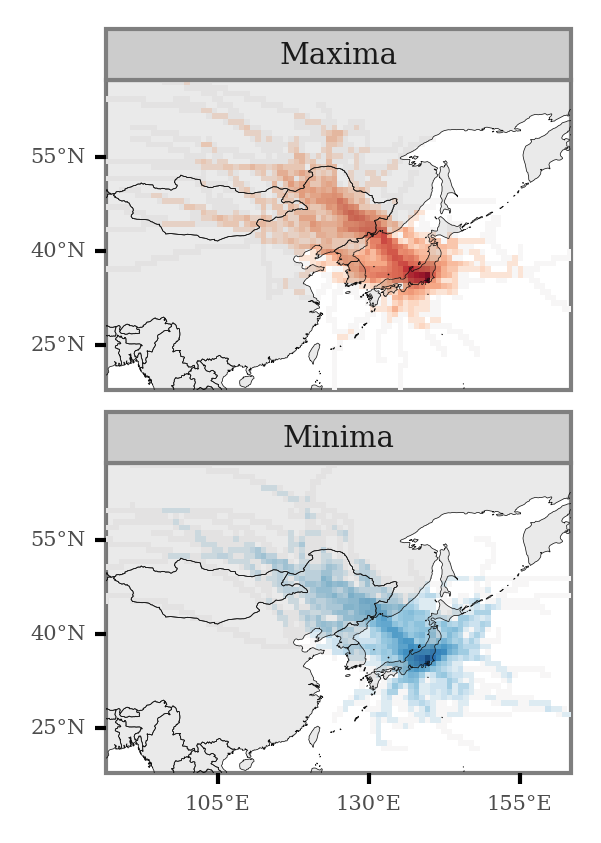

In [ ]:
(grid_intersections
 .groupby(['x', 'y', 'group'])
 .size()
 .rename('n')
 .reset_index()
 .merge(x_y_poly)
 .assign(n=lambda dd: np.where(dd.group=='Minima', -dd.n, dd.n))
 .assign(n=lambda dd: negative_log(dd.n))
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map(p9.aes(fill='n', geometry='cell'), size=0)
       + p9.geom_map(data=world, size=.1, alpha=.1)
       + p9.facet_wrap(['group'], ncol=1)
       + p9.theme(dpi=300, panel_grid=p9.element_blank(), figure_size=(2, 3),
                  axis_text=p9.element_text(size=5), strip_text=p9.element_text(size=7))
       + p9.labs(fill='')
       + p9.scale_fill_continuous('RdBu_r', limits=(-2.2, 2.2))
       + p9.scale_alpha_continuous(trans='sqrt')
       + p9.guides(fill=False, alpha=False)
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(90, 160), breaks=[105, 130, 155])
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(20, 65), breaks=[25, 40, 55]))
).draw().savefig('../output/figures/japan_minmax_grids.pdf', bbox_inches='tight')

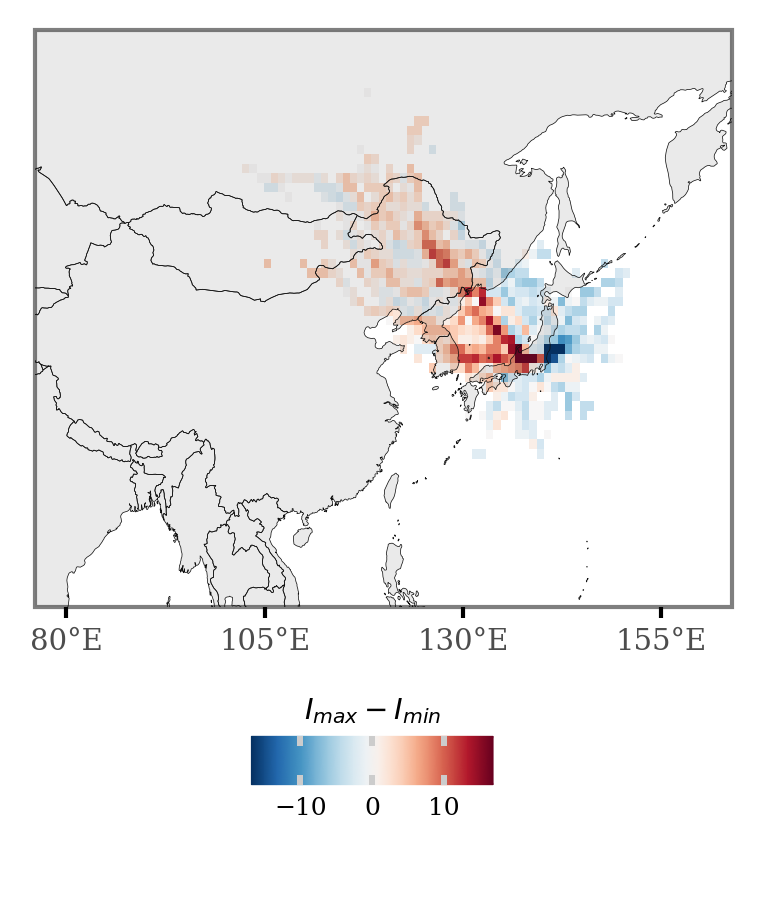

In [ ]:
(grid_intersections
 .groupby(['x', 'y', 'group'])
 .size()
 .rename('n')
 .reset_index()
 .pivot(['x', 'y'], 'group', 'n')
 .fillna(0)
 .assign(diff=lambda dd: dd['Maxima'] - dd['Minima'])
 .assign(fc=lambda dd: np.log2(dd['Maxima'] / dd['Minima']))
 .sort_values('diff')
 .reset_index()
 .merge(x_y_poly)
 .assign(total_n=lambda dd: dd['Maxima'] + dd['Minima'])
 .loc[lambda dd: dd.total_n >= 4]
 .sort_values('fc')
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map(p9.aes(fill='diff', geometry='cell'), size=.0)
       + p9.geom_map(data=world, size=.1, alpha=.1)
       + p9.scale_fill_continuous('RdBu_r', limits=(16, -16))
       + p9.scale_alpha_continuous(trans='log10')
       + p9.theme(dpi=300, panel_grid=p9.element_blank(), plot_background=p9.element_blank(),
                  legend_background=p9.element_blank(), legend_key_size=8,
                  legend_text=p9.element_text(size=6, va='bottom', ha='center'), legend_title_align='center',
                  legend_title=p9.element_text(size=7), figure_size=(3, 2.5), legend_position='bottom',
                  axis_text_y=p9.element_blank(), axis_ticks_major_y=p9.element_blank())
       + p9.labs(fill='$I_{max} - I_{min}$')
      + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(80, 160), breaks=[80, 105, 130, 155])
      + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(15, 65), breaks=[25, 40, 55])
)).draw().savefig('../output/figures/japan_max_minus_min.pdf', bbox_inches='tight')

## LIDAR and SWC plots

In [25]:
absc_df = (pd.read_csv('../data/absc532_1064_TKB_TKO_TYM_2010_16.csv')
            .assign(date=lambda dd: pd.to_datetime(dd.date))
)


In [26]:
swc_df = (pd.read_csv('../data/subweekly_TW84_absc532_1064_TKB_TKO_TYM_2010_16.csv')
          .rename(columns={'DatesH': 'date'})
          .assign(date=lambda dd: pd.to_datetime(dd['date']))
)

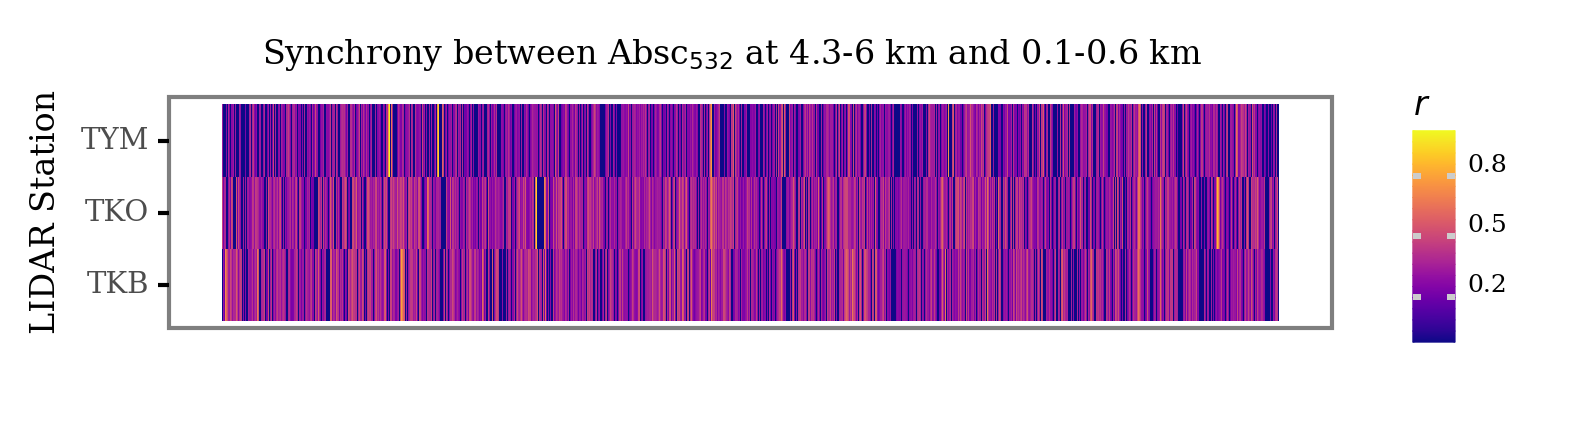

<ggplot: (8791575057098)>

In [27]:
(swc_df
.set_index('date')
.melt(ignore_index=False)
.fillna(0)
.pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('dd.index', 'variable', fill='value')
               + p9.geom_tile()
               + p9.scale_x_datetime(breaks=date_breaks('2 year'))
               + p9.scale_fill_continuous('plasma', breaks=[.2, .5, .8])
               + p9.labs(x='', y='LIDAR Station', title='Synchrony between Absc$_{532}$ at 4.3-6 km and 0.1-0.6 km ', fill='$r$')
               + p9.theme(figure_size=(5, 1),
                          dpi=300,
                          legend_key_size=7,
                          axis_ticks_major_x=p9.element_blank(),
                          axis_text_x=p9.element_blank(),
                          legend_text=p9.element_text(size=6, va='bottom'),
                          panel_grid=p9.element_blank(),
                          title=p9.element_text(size=8)))
)

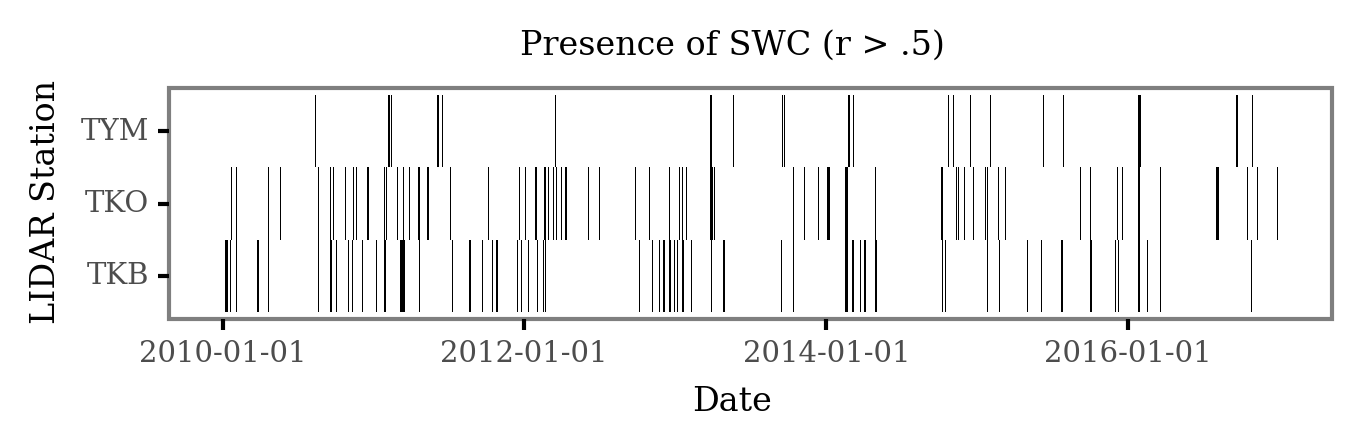

<ggplot: (8791574904667)>

In [28]:
swc_presence = swc_df.set_index('date') > .5
(swc_presence
.melt(ignore_index=False)
.pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('dd.index', 'variable', fill='value')
               + p9.geom_tile()
               + p9.scale_x_datetime(breaks=date_breaks('2 year'))
               + p9.scale_fill_manual(['white', 'black'])
               + p9.guides(fill=False)
               + p9.labs(x='Date', y='LIDAR Station', title='Presence of SWC (r > .5)')
               + p9.theme(figure_size=(5, 1),
                          dpi=300,
                          panel_grid=p9.element_blank(),
                          title=p9.element_text(size=8)))
)

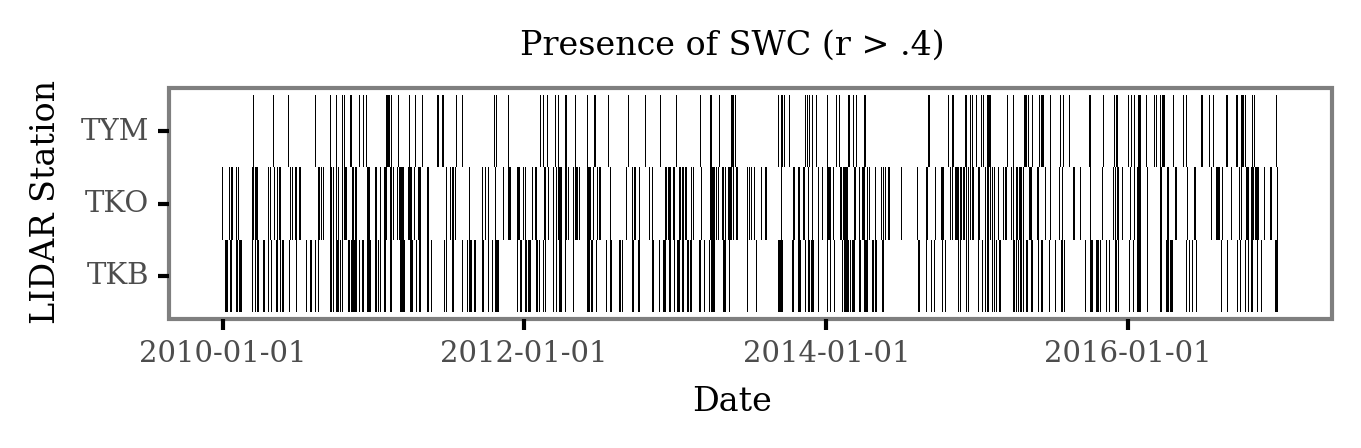

<ggplot: (8791572713942)>

In [29]:
swc_presence = swc_df.set_index('date') > .4
(swc_presence
.melt(ignore_index=False)
.pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('dd.index', 'variable', fill='value')
               + p9.geom_tile()
               + p9.scale_x_datetime(breaks=date_breaks('2 year'))
               + p9.scale_fill_manual(['white', 'black'])
               + p9.guides(fill=False)
               + p9.labs(x='Date', y='LIDAR Station', title='Presence of SWC (r > .4)')
               + p9.theme(figure_size=(5, 1),
                          dpi=300,
                          panel_grid=p9.element_blank(),
                          title=p9.element_text(size=8)))
)

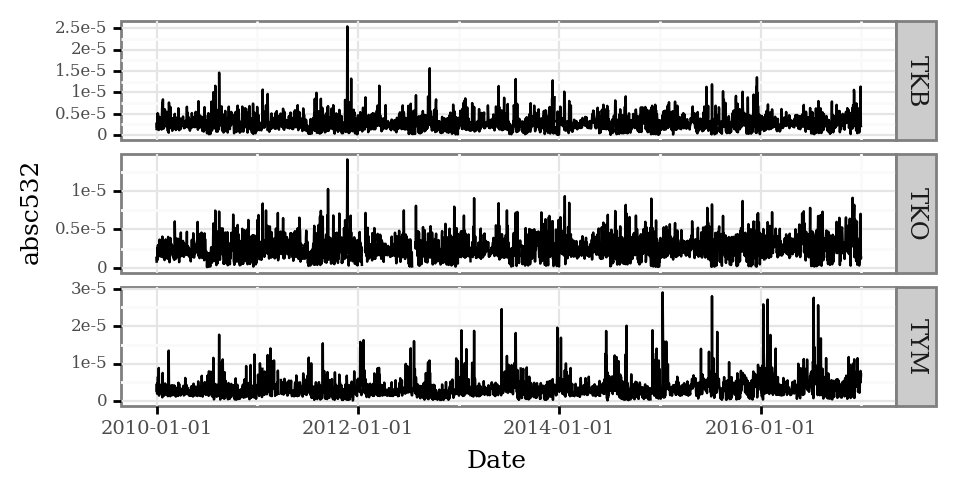

<ggplot: (8791572229699)>

In [30]:
(absc_df
 .set_index('date')
 .melt(ignore_index=False)
 .assign(station=lambda dd: dd.variable.str[-3:])
 .assign(wavelength=lambda dd: dd.variable.str[4:-4].astype(int))
 .loc[lambda dd: dd.wavelength==532]
 .pipe(lambda dd: p9.ggplot(dd) 
                + p9.aes('dd.index', 'value') 
                + p9.facet_grid('station ~ .', scales='free_y')
                + p9.scale_x_datetime(breaks=date_breaks('2 year'))
                + p9.geom_line()
                + p9.labs(x='Date', y='absc532')
                + p9.theme(figure_size=(5, 2.5), axis_text_y=p9.element_text(size=6))
)
)

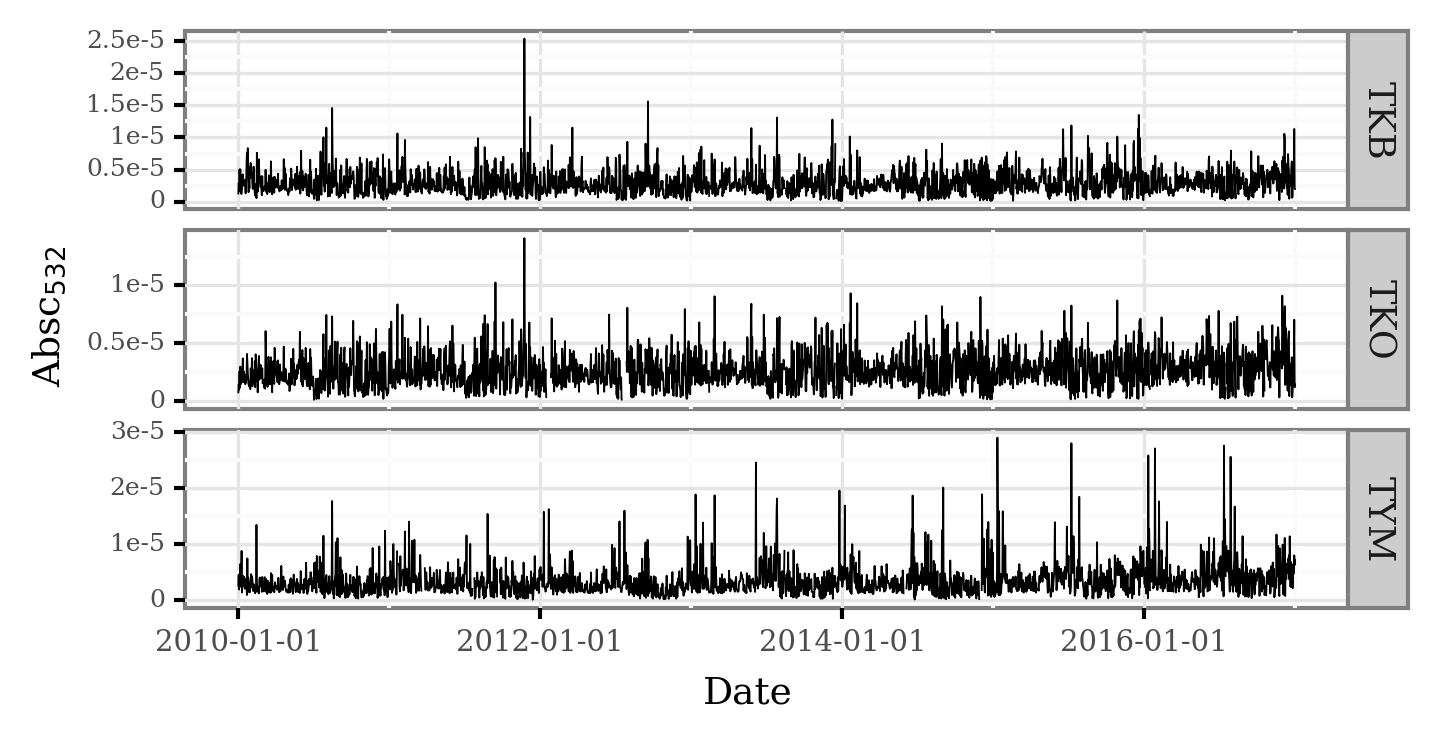

<ggplot: (8791572832985)>

In [31]:
absc_df_long = (absc_df
 .set_index('date')
 .melt(ignore_index=False)
 .assign(station=lambda dd: dd.variable.str[-3:])
 .assign(wavelength=lambda dd: dd.variable.str[4:-4].astype(int))
 .loc[lambda dd: dd.wavelength==532]
)
(absc_df_long.pipe(lambda dd: p9.ggplot(dd) 
                + p9.aes('dd.index', 'value') 
                + p9.facet_grid('station ~ .', scales='free_y')
                + p9.scale_x_datetime(breaks=date_breaks('2 year'))
                + p9.geom_line(size=.25)
                + p9.labs(x='Date', y='Absc$_{532}$')
                + p9.theme(figure_size=(5, 2.5),
                           axis_text_y=p9.element_text(size=6),
                           dpi=300)
)
)

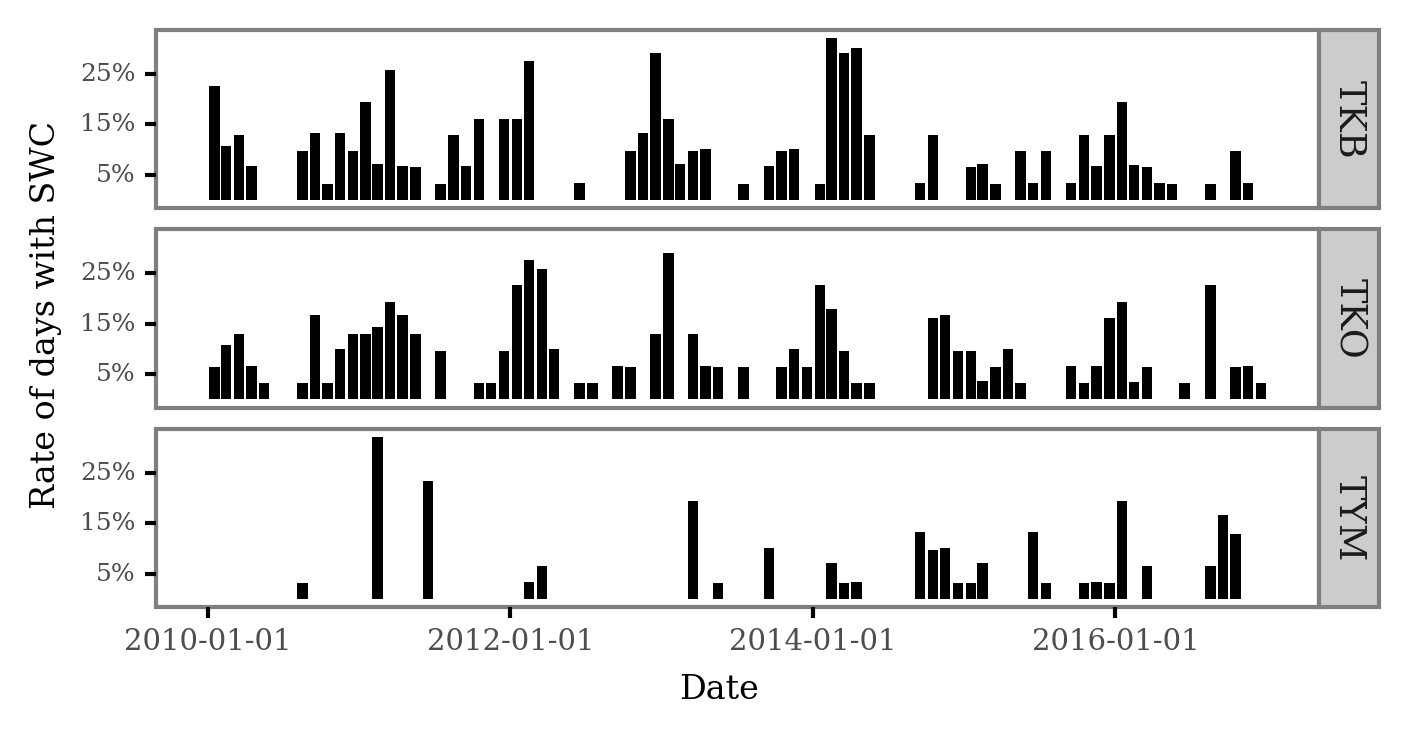

<ggplot: (8791574884756)>

In [33]:
monthly_swc = (swc_df
 .set_index('date')
 .apply(lambda x: x > .5)
 .resample('M')
 .mean()
 .melt(ignore_index=False)
 .assign(date=lambda dd: dd.index - pd.to_timedelta('14 days'))
)
(monthly_swc
  .pipe(lambda dd: p9.ggplot(dd)
                + p9.aes('date', 'value')
                + p9.geom_col(fill='black')
                + p9.facet_grid('variable ~ .')
                + p9.scale_x_datetime(breaks=date_breaks('2 year'))
                + p9.labs(x='Date', y='Rate of days with SWC')
                + p9.scale_y_continuous(labels=percent_format(), breaks=[.05, .15, .25])
                + p9.theme(figure_size=(5, 2.5),
                           axis_text_y=p9.element_text(size=6),
                           axis_title=p9.element_text(size=8),
                           panel_grid=p9.element_blank(),
                           dpi=300)
)
)

In [35]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(dplyr)
library(ggplot2)

In [ ]:
absc_df_long = absc_df_long.reset_index()

In [ ]:
monthly_swc = monthly_swc.rename(columns={'variable': 'station'})

R[write to console]: Saving 5.33 x 3 in image



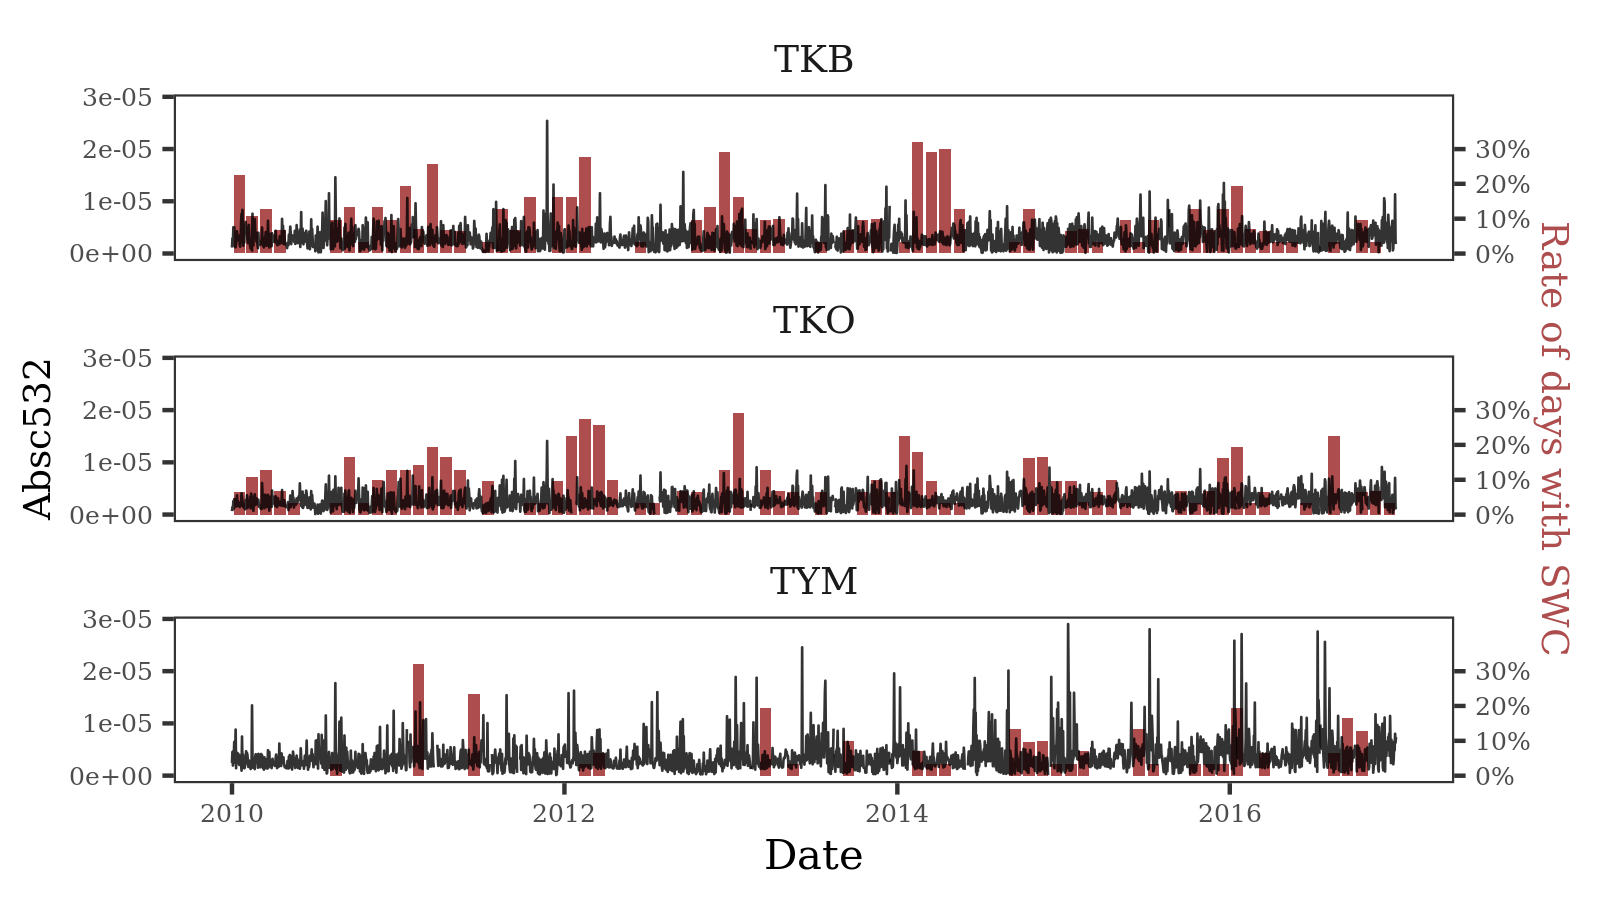

In [ ]:
%%R -i absc_df_long -i monthly_swc -w 1600 -h 900 -r 300

coef <- 1.5e4
# library(extrafont)
# font_import('Serif')

f <- ggplot(absc_df_long) + 
    aes(date, value) +
    theme_bw() +
    scale_y_continuous(name='Absc532',
                    #    limits=c(0, .00004),
                       sec.axis=sec_axis(trans=~.*coef, name='Rate of days with SWC', breaks=c(0, .1, .2, .3), labels=scales::percent)) +
    geom_col(aes(date, y=value / coef), fill='#AE4D4D', data=monthly_swc) +
    geom_line(size=.3, alpha=.8) +
    facet_wrap('station', ncol=1) +
    labs(x='Date') + 
    theme(axis.title.y.right = element_text(color = '#AE4D4D', size=9),
          axis.title.y.left = element_text(size=9),
          axis.title.x = element_text(size=10),
          panel.grid=element_blank(),
          axis.text=element_text(size=6),
          text=element_text(family='Serif'),
          strip.text = element_text(size=9),
          strip.background = element_rect(size=.0, color=NA, fill=NA))
ggsave('../output/figures/combi_swc_absc.pdf', f, device=cairo_pdf)
f

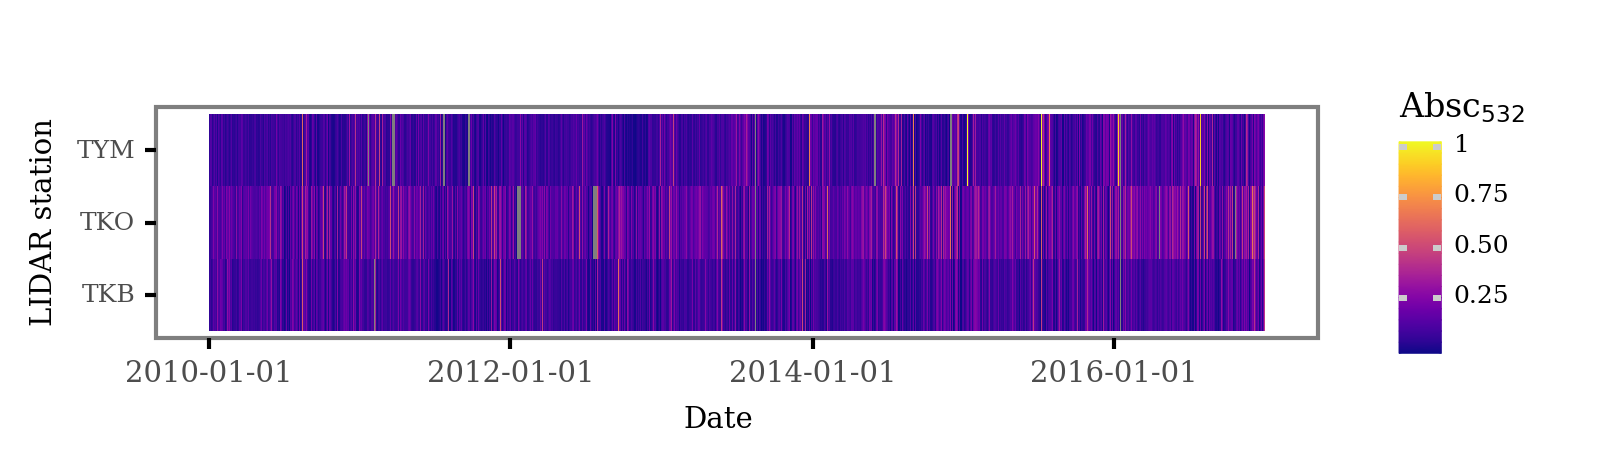

<ggplot: (8731496656388)>

In [ ]:
(absc_df
 .set_index('date')
 .melt(ignore_index=False)
 .assign(station=lambda dd: dd.variable.str[-3:])
 .assign(wavelength=lambda dd: dd.variable.str[4:-4].astype(int))
 .loc[lambda dd: dd.wavelength==532]
 .reset_index()
 .groupby('station')
 .apply(lambda dd: dd.assign(value=dd.value / dd.value.max()))
 .reset_index(drop=True)
 .pipe(lambda dd: p9.ggplot(dd) 
                + p9.aes('date', 'station', fill='value') 
                + p9.scale_x_datetime(breaks=date_breaks('2 year'))
                + p9.geom_tile()
                + p9.labs(x='Date', y='LIDAR station', fill='Absc$_{532}$')
                + p9.scale_fill_continuous('plasma')
                + p9.theme(figure_size=(5, 1),
                           axis_text_y=p9.element_text(size=6),
                           legend_key_size=7,
                           legend_title=p9.element_text(size=8),
                           panel_grid=p9.element_blank(),
                           axis_title=p9.element_text(size=7),
                           legend_text=p9.element_text(size=6, va='bottom'),
                           dpi=300)
)
)
